In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping , ReduceLROnPlateau
from nltk.stem import PorterStemmer , WordNetLemmatizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report
from tensorflow.keras.layers import Conv1D , Flatten , Dense , Embedding , Dropout , MaxPooling1D
from tensorflow.keras import Sequential


In [10]:
nltk.download("stopwords")
nltk.download("words")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MrLaptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\MrLaptop\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MrLaptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\tweets.csv')
df

,tweet_id,Emotion,Text
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [12]:
df.describe()

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


In [13]:
df.shape

(40000, 3)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  40000 non-null  int64 
 1   Emotion   40000 non-null  object
 2   Text      40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [15]:
df["Text"][1]

'Layin n bed with a headache  ughhhh...waitin on your call...'

In [16]:
df["Emotion"].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [17]:
df["Emotion"].value_counts(ascending = True)

Emotion
anger          110
boredom        179
enthusiasm     759
empty          827
hate          1323
relief        1526
fun           1776
surprise      2187
love          3842
sadness       5165
happiness     5209
worry         8459
neutral       8638
Name: count, dtype: int64

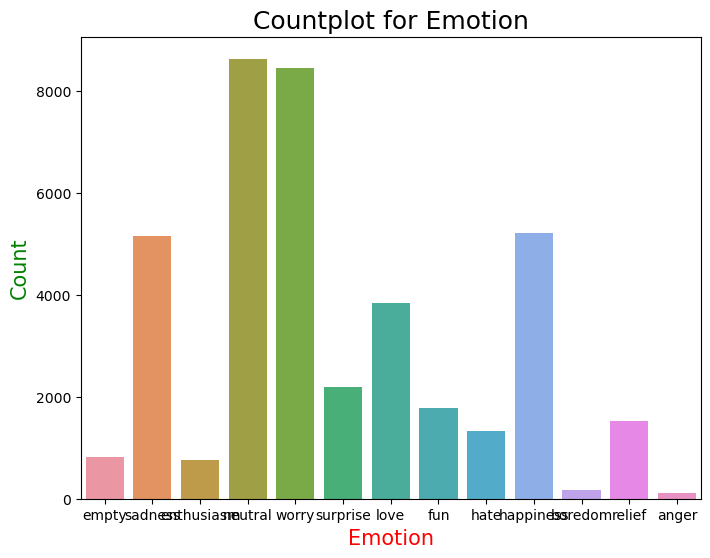

In [18]:
## Countplot for Emotion

plt.figure(figsize = (8,6))
sns.countplot(x = "Emotion" , data = df)
plt.title("Countplot for Emotion" , fontsize = 18 , c="k")
plt.xlabel("Emotion" , fontsize = 15 , c = "r")
plt.ylabel("Count" , fontsize = 15 , c = "g")
plt.show()

C:\Users\MrLaptop\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


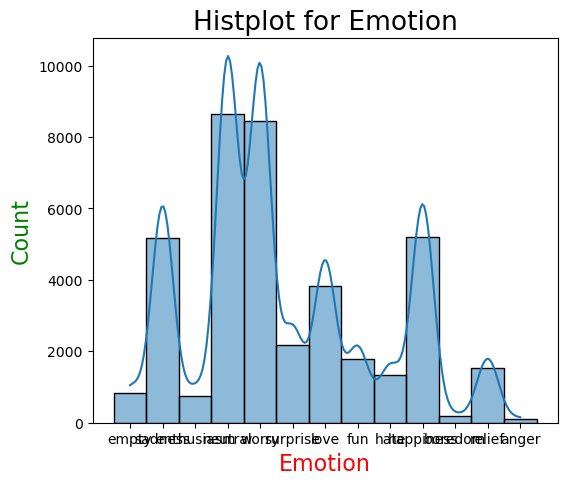

In [19]:
plt.figure(figsize = (6,5))
sns.histplot(x="Emotion" , kde = True , bins = 30 , data = df)
plt.title("Histplot for Emotion" , fontsize = 19 , c="k")
plt.xlabel("Emotion" , fontsize = 16 , c="r")
plt.ylabel("Count" , fontsize = 16 , c="g")
plt.show()

In [20]:
df.isnull().sum()

tweet_id    0
Emotion     0
Text        0
dtype: int64

In [21]:
df["Text"].value_counts()

Text
I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9                            14
FREE UNLIMITED RINGTONES!!! - http://tinyurl.com/freeringring - USA ONLY - Awesome 4 iphone                                             13
Happy Mother's Day!                                                                                                                     10
Happy Mothers Day                                                                                                                       10
happy mother's day                                                                                                                       8
                                                                                                                                        ..
Sick daddy  send prayer his way                                                                                                          1
Laura's gone for the w

In [22]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
39995    False
39996    False
39997    False
39998    False
39999    False
Length: 40000, dtype: bool

In [23]:
df.duplicated().sum()

0

Process missing values

In [24]:
## process missing values in text

df["Text"].fillna("unknown" , inplace = True)

df["Text"].replace("" , inplace = True)


C:\Users\MrLaptop\AppData\Local\Temp\ipykernel_6844\2283234116.py:5: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df["Text"].replace("" , inplace = True)


Preprocessing on Text

In [25]:
## preprocessing text

def process_Text(Text):
    
    ## transform text to lowercase
    Text = Text.lower()
    
    ## remove punctuations
    Text = re.sub(r"[^\w\s]" , "" , Text)
    
    ## remove numbers
    Text = re.sub(r"\d+" , "" , Text)
    
    ## split text into tokens
    tokens = word_tokenize(Text)
    
    ## remove stopwords
    stop_words = set(stopwords.words("English"))
    tokens = [word for word in tokens if word not in stop_words]
    
    ## Stemmer
    stemmer = PorterStemmer()
    stemme_tokens = [stemmer.stem(token) for token in tokens]
    
    ## Lemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatize_tokens = [lemmatizer.lemmatize(token) for token in stemme_tokens]
    
    return " ".join(lemmatize_tokens)


In [26]:
df["processed_Text"] = df["Text"].apply(process_Text)

In [27]:
df["processed_Text"]

0        tiffanylu know listenin bad habit earlier star...
1                    layin n bed headach ughhhhwaitin call
2                              funer ceremonygloomi friday
3                                    want hang friend soon
4        dannycastillo want trade someon houston ticket...
                               ...                        
39995                                      johnlloydtaylor
39996                                happi mother day love
39997    happi mother day mommi woman man long your mom...
39998    niariley wassup beauti follow peep new hit sin...
39999    mopedronin bullet train tokyo gf visit japan s...
Name: processed_Text, Length: 40000, dtype: object

In [28]:
df["processed_Text"][1]

'layin n bed headach ughhhhwaitin call'

In [29]:
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()

df["Emotion"] = Encoder.fit_transform(df["Emotion"])
df["Emotion"]

0         2
1        10
2        10
3         3
4         8
         ..
39995     8
39996     7
39997     7
39998     5
39999     7
Name: Emotion, Length: 40000, dtype: int32

In [30]:
df["Emotion"].unique()

array([ 2, 10,  3,  8, 12, 11,  7,  4,  6,  5,  1,  9,  0])

In [31]:
df.head(10).style.background_gradient(cmap = "Blues")

,tweet_id,Emotion,Text,processed_Text
0,1956967341,2,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,tiffanylu know listenin bad habit earlier start freakin part
1,1956967666,10,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headach ughhhhwaitin call
2,1956967696,10,Funeral ceremony...gloomy friday...,funer ceremonygloomi friday
3,1956967789,3,wants to hang out with friends SOON!,want hang friend soon
4,1956968416,8,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",dannycastillo want trade someon houston ticket one
5,1956968477,12,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,reping ghostridah didnt go prom bc bf didnt like friend
6,1956968487,10,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, & he wants me 2! scandalous!",sleep im think old friend want he marri damn amp want scandal
7,1956968636,12,Hmmm. http://www.djhero.com/ is down,hmmm httpwwwdjherocom
8,1956969035,10,@charviray Charlene my love. I miss you,charviray charlen love miss
9,1956969172,10,@kelcouch I'm sorry at least it's Friday?,kelcouch im sorri least friday


In [32]:
data = df.drop("Text" , axis = 1)
data

,tweet_id,Emotion,processed_Text
0,1956967341,2,tiffanylu know listenin bad habit earlier star...
1,1956967666,10,layin n bed headach ughhhhwaitin call
2,1956967696,10,funer ceremonygloomi friday
3,1956967789,3,want hang friend soon
4,1956968416,8,dannycastillo want trade someon houston ticket...
...,...,...,...
39995,1753918954,8,johnlloydtaylor
39996,1753919001,7,happi mother day love
39997,1753919005,7,happi mother day mommi woman man long your mom...
39998,1753919043,5,niariley wassup beauti follow peep new hit sin...


Split Data to X and y

In [33]:
X = data["processed_Text"]

y = df["Emotion"]

In [34]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , 
                                                      shuffle = True , random_state = 42)

In [35]:
print("x_train shape" , x_train.shape)
print("x_test shape" , x_test.shape)
print("y_train shape" , y_train.shape)
print("y_test shape" , y_test.shape)

x_train shape (32000,)
x_test shape (8000,)
y_train shape (32000,)
y_test shape (8000,)


In [36]:
## Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [37]:
# pad sequences#

max_len = 100

train_sequences = pad_sequences(train_sequences , maxlen = max_len ,
                               padding = "post" ,
                               truncating = "post")


test_sequences = pad_sequences(test_sequences , maxlen = max_len ,
                              padding = "post" , 
                              truncating = "post")


In [38]:
## calculate vocab_size

vocab_size = len(tokenizer.word_index) + 1

## set embedding dim

embedding_dim = 50

## set num of classes

num_classes = 13

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.regularizers import l2


model = Sequential()


model.add(Embedding(input_dim = vocab_size , 
                   output_dim = embedding_dim ,
                   input_length = max_len))
model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.002)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  

model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.002)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())


model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.5))


model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_sequences, y_train, epochs=40, batch_size=64, 
                    validation_data=(test_sequences, y_test))


test_loss, test_acc = model.evaluate(test_sequences, y_test)
print(f'Test Accuracy: {test_acc}')

Epoch 1/40


C:\Users\MrLaptop\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.1937 - loss: 2.6229 - val_accuracy: 0.2083 - val_loss: 2.1968
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.2161 - loss: 2.2020 - val_accuracy: 0.2083 - val_loss: 2.1624
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2127 - loss: 2.1641 - val_accuracy: 0.2175 - val_loss: 2.1526
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2129 - loss: 2.1570 - val_accuracy: 0.2083 - val_loss: 2.1505
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2143 - loss: 2.1519 - val_accuracy: 0.2175 - val_loss: 2.1493
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2177 - loss: 2.1471 - val_accuracy: 0.2175 - val_loss: 2.1489
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2150 - loss: 2.1484 - val_accuracy: 0.2175 - val_loss: 2.1485
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2192 - loss: 2.1516 - val_accurac

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 50)          │     1,907,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (64, 98, 64)           │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (64, 47, 128)          │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (64, 23, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 23, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (64, 2944)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 128)              │       376,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 13)               │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,982,889 (26.64 MB)

 Trainable params: 2,327,629 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,655,260 (17.76 MB)

In [41]:
test_accuracy , test_loss = model.evaluate(test_sequences , y_test)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2191 - loss: 2.1415


In [42]:
y_pred = model.predict(test_sequences)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [43]:
probs = np.max(y_pred , axis = 1)
y_pred_class = np.argmax(y_pred , axis = 1)

In [44]:
report_dict = classification_report(y_test , y_pred_class , output_dict = True)
df_report = pd.DataFrame(report_dict).transpose()
df_report

C:\Users\MrLaptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MrLaptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MrLaptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,19.0000
1,0.000000,0.000000,0.000000,31.0000
2,0.000000,0.000000,0.000000,162.0000
3,0.000000,0.000000,0.000000,163.0000
4,0.000000,0.000000,0.000000,338.0000
5,0.000000,0.000000,0.000000,1028.0000
6,0.000000,0.000000,0.000000,268.0000
7,0.000000,0.000000,0.000000,762.0000
8,0.217500,1.000000,0.357290,1740.0000
9,0.000000,0.000000,0.000000,352.0000


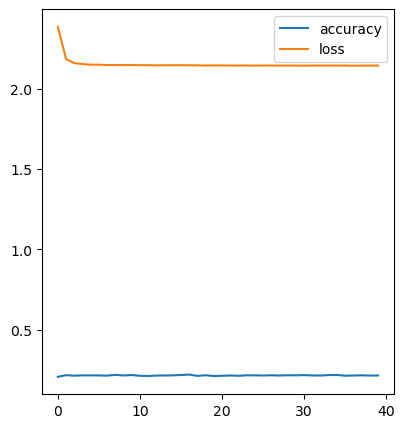

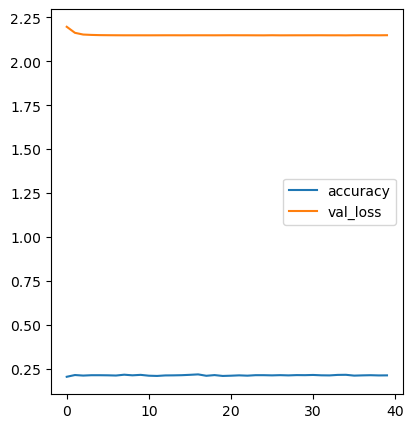

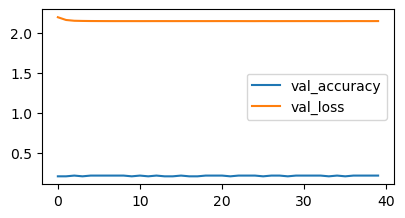

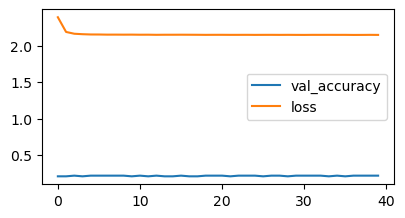

In [45]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"] , label = "accuracy")
plt.plot(history.history["loss"] , label = "loss")
plt.legend()
plt.show()


plt.figure(figsize = (10,5))
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"] , label = "accuracy")
plt.plot(history.history["val_loss"] , label = "val_loss")
plt.legend()
plt.show()


plt.figure(figsize = (10,5))
plt.subplot(2,2,3)
plt.plot(history.history["val_accuracy"] , label = "val_accuracy")
plt.plot(history.history["val_loss"] , label = "val_loss")
plt.legend()
plt.show()


plt.figure(figsize = (10,5))
plt.subplot(2,2,4)
plt.plot(history.history["val_accuracy"] , label = "val_accuracy")
plt.plot(history.history["loss"] , label = "loss")
plt.legend()
plt.show()


Predict The Emotion

In [46]:
from textblob import TextBlob

def sentiment_analysis(processed_Text):
    blob = TextBlob(processed_Text)
    classified = blob.sentiment.polarity
    
    if classified <= 0:
        return "sadness"
    
    elif 0 < classified < 2:
        return "anger"
    
    elif 1 < classified  <3:
        return "fear"
    
    elif 2 < classified  <4:
        return "surprise"
    
    elif  3 < classified  <5:
        return "love"
    
    else:
        return "happy"
    

test_Texts = [

    "this situation is making me really nervous and anxious",
    "this makes me so angry, i can not stand it anymore",
    " it is hard to find joy in anything these days"

]


for text in test_Texts:
    sentiment = sentiment_analysis(text)
    print(f" test_texts: {text}\nsentiment :{sentiment}\n")

 test_texts: this situation is making me really nervous and anxious
sentiment :sadness

 test_texts: this makes me so angry, i can not stand it anymore
sentiment :sadness

 test_texts:  it is hard to find joy in anything these days
sentiment :anger

